# Neural Network I

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torchvision

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class FashionMNIST:
    def __init__(self, batch_size, resize = (28, 28)):
        self.batch_size = batch_size
        
        trans = torchvision.transforms.Compose([torchvision.transforms.Resize(resize),
                                    torchvision.transforms.ToTensor()])
        
        self.train = torchvision.datasets.FashionMNIST(
            root="../data", train=True, transform=trans, download=True)
        
        self.val = torchvision.datasets.FashionMNIST(
            root="../data", train=False, transform=trans, download=True)
    
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers= 4)

In [3]:
class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma = 0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hiddens = num_hiddens
        self.lr = lr

        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad = True) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad = True))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad = True) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad = True))

        
    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        linear = torch.matmul(X, self.W1) + self.b1
        zeros = torch.zeros_like(linear)                   # Setting up for relu operation
        H = torch.max(linear, zeros)                       # Computing relu, where linear < 0 = 0, linear > 0 = linear
        y_hat = torch.matmul(H, self.W2) + self.b2
        return y_hat
    
    def loss(self, y_hat, y):
        return -torch.log(y_hat[range(len(y_hat)), y]).mean()
    
    def optimizer(self):
        return optim.SGD([self.W1, self.b1, self.W2, self.b2], self.lr) 

In [4]:
class Trainer:
    def __init__(self, max_epochs):
        self.max_epochs = max_epochs
        
    def prepare_data(self, data):
        self.num_train_batches = len(data.get_dataloader(train = True))
        self.num_val_batches = len(data.get_dataloader(train = False))
        
    def prepare_model(self, model):
        self.model = model
    
    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = self.model.optimizer()
        
        for epoch in range(1, self.max_epochs + 1):
                self.fit_epoch()
        
    def fit_epoch(self):
        for batch_index, (X, y) in enumerate(data.get_dataloader(train = True)):
            y_hat = self.model(X)
            loss = self.model.loss(y_hat, y)
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
            self.optim.step()

In [5]:
data = FashionMNIST(batch_size = 64)
model = MLP(num_inputs=784, num_outputs=10, num_hiddens=256, lr=1e-5)
trainer = Trainer(max_epochs = 5)
trainer.fit(model, data)

In [6]:
# Do not refresh as it resets
frame = iter(data.get_dataloader(train = False))

In [7]:
# Refresh this for a new batch of images
X, y = next(frame)
preds = model(X).argmax(axis=1)
print('Accuracy:', sum(preds == y)/len(y))

Accuracy: tensor(0.3906)


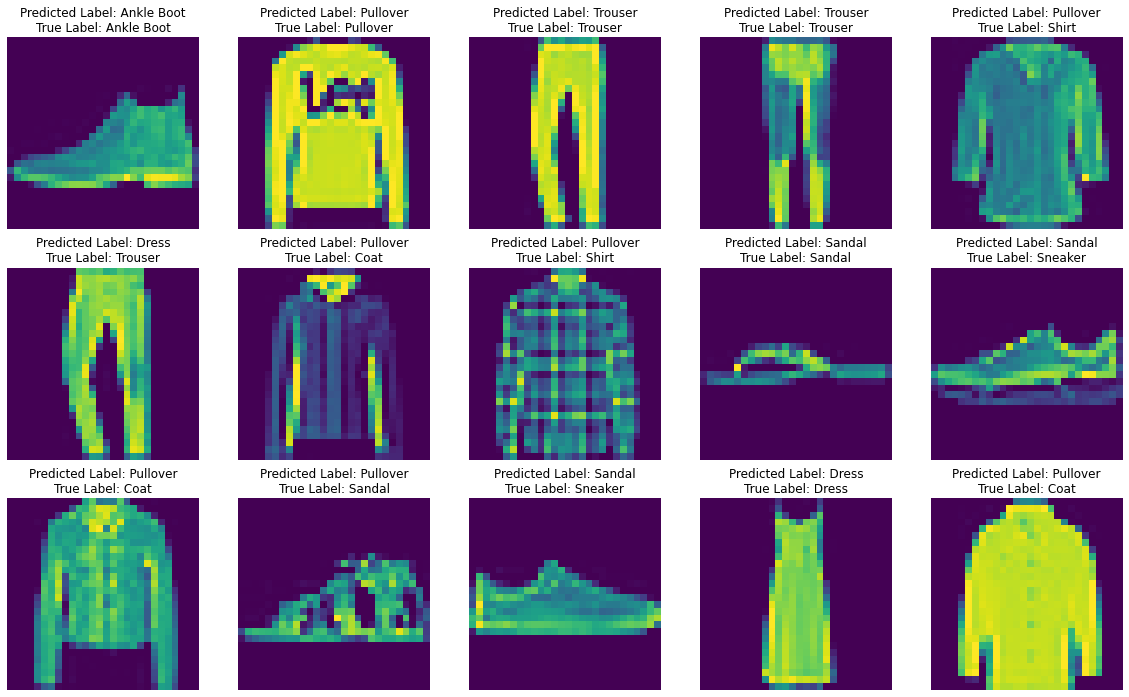

In [8]:
labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

fig = plt.figure(figsize=(20,12))
for i in range(0,15):
    ax = fig.add_subplot(3,5, i+1)
    no_channelX = X[:, 0, :, :]
    ax.imshow(no_channelX[i])
    ax.set_title('Predicted Label: {pred}\nTrue Label: {true}'.format(pred = labels[preds[i]], true = labels[y[i]]))
    #ax.set_title(labels[y[i]])
    plt.axis('off')